# Benchmarking feature selection algorithms in the molecular property prediction space


In [5]:
# Datasets
from tdc.single_pred import ADME, Tox

# Additional functions in a separate ipynb file
from ipynb.fs.full.AZ_additional_functions import *

# General use 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#import shap
import joblib

import scipy
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# RDkit
from rdkit import Chem
from rdkit import RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Standardizing
from molvs import standardize_smiles

import warnings
warnings.filterwarnings('ignore')

In [6]:
benchmark = []

## Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

In [7]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [8]:
data_overview(df, split_LIPO)

Total number of molecules: 4200
Train set: 2940 - 70.0%
Validation set: 420 - 10.0%
Test set: 840 - 20.0%


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


In [9]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified: {}'.format(len(frag_compounds)))

Number of compounds modified: 1


In [10]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
New number of compounds: 4200 (0)


### Descriptors
Contain numerical information regarding the molecule 

In [11]:
descList = [i for i,j in Descriptors.descList]
#Molecular descriptor calculator
calculator = MolecularDescriptorCalculator(descList)
print('Calculator initialized. Total number of descriptors:', len(descList))

Calculator initialized. Total number of descriptors: 208


In [12]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (4200, 211)


In [13]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.10


### Fingerprints
Allows us to find patterns in molecule structures.

In [14]:
# FP_data = (num_mols x numVectorBits)
def generate_fingerprints(mol, fp_type="ECFP", r = 2, bits =1024):
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol,r,bits),fp_arr)    
    return fp_arr

In [15]:
# Generate fingerprints dataset and transform into a dataframe
fps = pd.DataFrame([generate_fingerprints(Chem.MolFromSmiles(mol)) for mol in df['Drug']],columns = np.arange(1,1025))
print('Shape of the actual fps structure:', fps.shape)

Shape of the actual fps structure: (4200, 1024)


### Generate splits, remove NaNs, and normalization


#### Train, validation, and test sets for both Descriptors and fingerprints

In [16]:
X_train, X_train_fps, y_train, X_val, X_val_fps, y_val, X_test, X_test_fps, y_test = train_val_test_split(df, split_LIPO, fps)

Data has been split


#### Remove NaNs values

In [17]:
X_train, X_train_fps, y_train, X_val, X_val_fps, y_val, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps)

Removed the following rows in the train set: Int64Index([1561], dtype='int64')


#### Data normalization required in linear models

In [18]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


## Data visualization

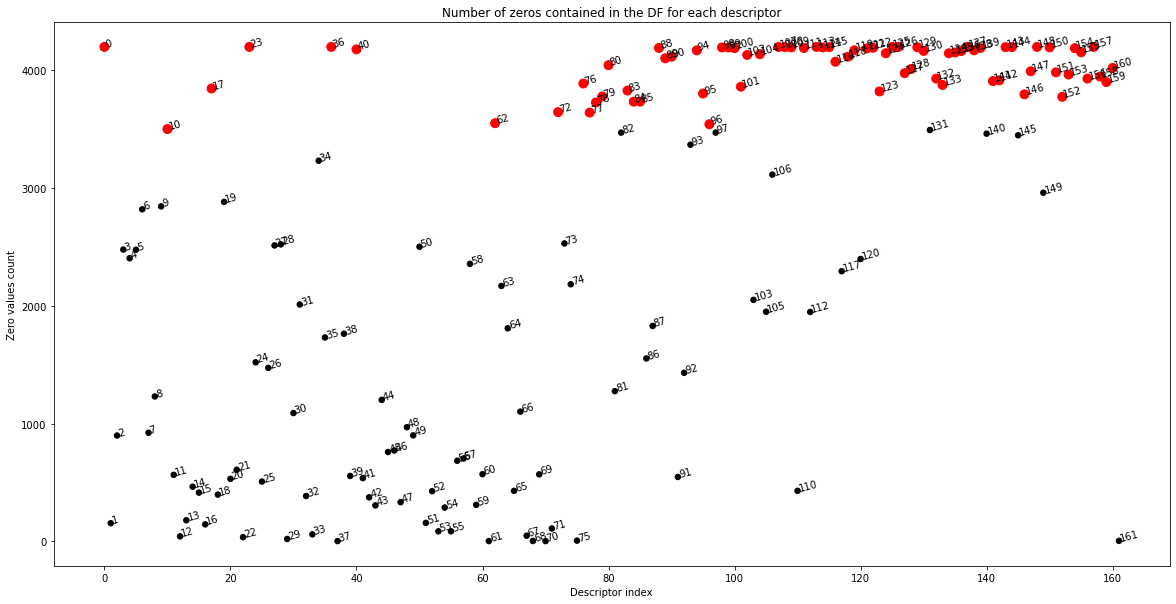

In [19]:
visualize_zeros(df)

## Building our baseline models

In order to get some initial results, we will now construct a few baseline models where all the features are included without any preprocessing.

We now compare the metrics obtained for each of the following models:
- Linear regression (**LR**)
- Random forest regressor (**RFR**)
- Decision tree regressor (**DTR**)
- Support vector machine (**SVM**)
- Multi-layer Perceptron regressor (**MLP**)
- XG Boost regressor (**XGB**) TBD

#### Descriptors

LR | R2: 0.599, MAE: 0.594, MSE: 0.597 | Training time: 0.1
RFR | R2: 0.646, MAE: 0.546, MSE: 0.527 | Training time: 14.4
DTR | R2: 0.260, MAE: 0.775, MSE: 1.102 | Training time: 0.3
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463 | Training time: 0.7
MLPR | R2: 0.652, MAE: 0.514, MSE: 0.517 | Training time: 3.1


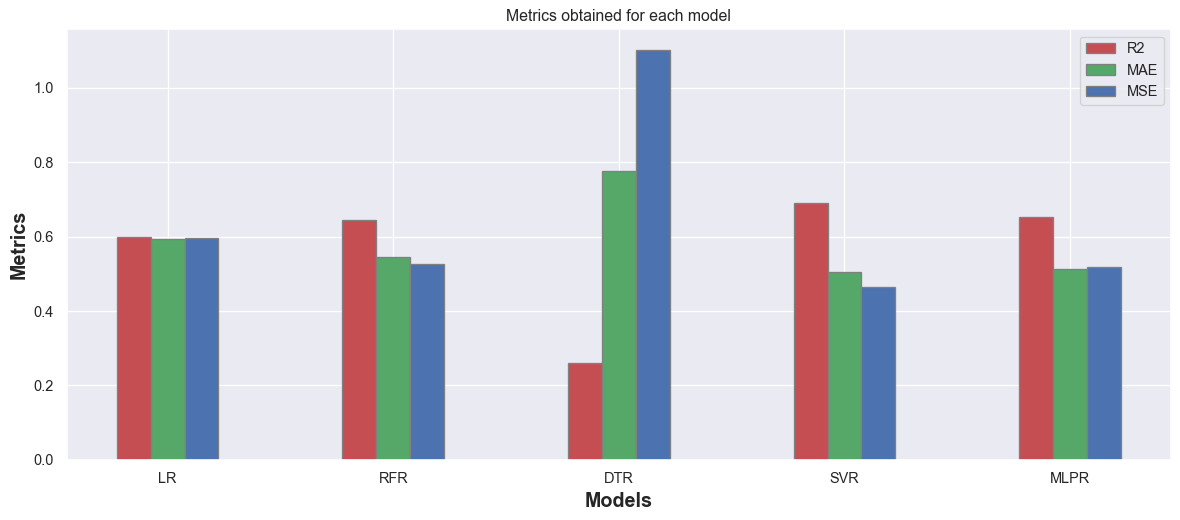

In [20]:
models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, False, X_train_norm, X_val_norm)

In [21]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

#### Fingerprints

In [22]:
# models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, True)

In [23]:
#We add the best model to our benchmark for a later comparison
# benchmark = add_to_benchmark(benchmark, models, results)

## Improving the model 

### 1 - Improving the model: Feature Selection - MRMR

In [24]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 32.97it/s]


LR | R2: -0.006, MAE: 0.997, MSE: 1.497 | Training time: 0.0
RFR | R2: -0.055, MAE: 0.956, MSE: 1.571 | Training time: 0.3
DTR | R2: -0.387, MAE: 1.077, MSE: 2.064 | Training time: 0.0
SVR | R2: -0.035, MAE: 0.994, MSE: 1.541 | Training time: 0.3
MLPR | R2: -0.006, MAE: 0.994, MSE: 1.497 | Training time: 0.7


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 33.16it/s]


LR | R2: -0.005, MAE: 0.996, MSE: 1.496 | Training time: 0.0
RFR | R2: -0.049, MAE: 0.952, MSE: 1.562 | Training time: 0.3
DTR | R2: -0.393, MAE: 1.081, MSE: 2.073 | Training time: 0.0
SVR | R2: -0.032, MAE: 0.991, MSE: 1.536 | Training time: 0.2
MLPR | R2: -0.009, MAE: 0.999, MSE: 1.502 | Training time: 0.4


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 36.02it/s]


LR | R2: 0.114, MAE: 0.937, MSE: 1.319 | Training time: 0.0
RFR | R2: 0.119, MAE: 0.867, MSE: 1.312 | Training time: 0.4
DTR | R2: -0.184, MAE: 0.994, MSE: 1.762 | Training time: 0.0
SVR | R2: 0.090, MAE: 0.930, MSE: 1.355 | Training time: 0.3
MLPR | R2: 0.086, MAE: 0.946, MSE: 1.360 | Training time: 1.1


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 37.66it/s]


LR | R2: 0.120, MAE: 0.931, MSE: 1.310 | Training time: 0.0
RFR | R2: 0.133, MAE: 0.862, MSE: 1.290 | Training time: 0.4
DTR | R2: -0.222, MAE: 0.995, MSE: 1.819 | Training time: 0.0
SVR | R2: 0.090, MAE: 0.929, MSE: 1.355 | Training time: 0.3
MLPR | R2: 0.104, MAE: 0.941, MSE: 1.333 | Training time: 1.3


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 38.26it/s]


LR | R2: 0.359, MAE: 0.790, MSE: 0.955 | Training time: 0.0
RFR | R2: 0.404, MAE: 0.722, MSE: 0.887 | Training time: 0.6
DTR | R2: 0.030, MAE: 0.881, MSE: 1.444 | Training time: 0.0
SVR | R2: 0.362, MAE: 0.765, MSE: 0.950 | Training time: 0.4
MLPR | R2: 0.386, MAE: 0.754, MSE: 0.914 | Training time: 2.7


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 38.25it/s]


LR | R2: 0.384, MAE: 0.767, MSE: 0.917 | Training time: 0.0
RFR | R2: 0.466, MAE: 0.687, MSE: 0.794 | Training time: 0.7
DTR | R2: 0.159, MAE: 0.808, MSE: 1.252 | Training time: 0.0
SVR | R2: 0.381, MAE: 0.741, MSE: 0.922 | Training time: 0.3
MLPR | R2: 0.400, MAE: 0.731, MSE: 0.892 | Training time: 2.3


100%|█████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


LR | R2: 0.389, MAE: 0.766, MSE: 0.910 | Training time: 0.0
RFR | R2: 0.473, MAE: 0.687, MSE: 0.784 | Training time: 0.8
DTR | R2: 0.114, MAE: 0.850, MSE: 1.319 | Training time: 0.0
SVR | R2: 0.403, MAE: 0.731, MSE: 0.889 | Training time: 0.3
MLPR | R2: 0.401, MAE: 0.729, MSE: 0.891 | Training time: 3.7


100%|█████████████████████████████████████████| 45/45 [00:01<00:00, 37.43it/s]


LR | R2: 0.400, MAE: 0.758, MSE: 0.893 | Training time: 0.0
RFR | R2: 0.485, MAE: 0.672, MSE: 0.766 | Training time: 0.8
DTR | R2: 0.152, MAE: 0.838, MSE: 1.262 | Training time: 0.0
SVR | R2: 0.421, MAE: 0.715, MSE: 0.862 | Training time: 0.4
MLPR | R2: 0.444, MAE: 0.705, MSE: 0.828 | Training time: 1.7


100%|█████████████████████████████████████████| 50/50 [00:01<00:00, 38.03it/s]


LR | R2: 0.409, MAE: 0.753, MSE: 0.880 | Training time: 0.0
RFR | R2: 0.468, MAE: 0.677, MSE: 0.792 | Training time: 1.0
DTR | R2: 0.013, MAE: 0.898, MSE: 1.469 | Training time: 0.0
SVR | R2: 0.440, MAE: 0.697, MSE: 0.834 | Training time: 0.3
MLPR | R2: 0.402, MAE: 0.711, MSE: 0.890 | Training time: 5.1


100%|█████████████████████████████████████████| 55/55 [00:01<00:00, 36.42it/s]


LR | R2: 0.409, MAE: 0.746, MSE: 0.879 | Training time: 0.0
RFR | R2: 0.521, MAE: 0.645, MSE: 0.713 | Training time: 1.1
DTR | R2: 0.061, MAE: 0.879, MSE: 1.398 | Training time: 0.0
SVR | R2: 0.456, MAE: 0.672, MSE: 0.810 | Training time: 0.4
MLPR | R2: 0.372, MAE: 0.701, MSE: 0.935 | Training time: 3.5


100%|█████████████████████████████████████████| 60/60 [00:01<00:00, 38.56it/s]


LR | R2: 0.429, MAE: 0.732, MSE: 0.849 | Training time: 0.0
RFR | R2: 0.551, MAE: 0.623, MSE: 0.668 | Training time: 1.4
DTR | R2: 0.129, MAE: 0.830, MSE: 1.296 | Training time: 0.0
SVR | R2: 0.490, MAE: 0.645, MSE: 0.760 | Training time: 0.4
MLPR | R2: 0.394, MAE: 0.701, MSE: 0.901 | Training time: 6.1


100%|█████████████████████████████████████████| 65/65 [00:01<00:00, 37.11it/s]


LR | R2: 0.448, MAE: 0.721, MSE: 0.821 | Training time: 0.0
RFR | R2: 0.559, MAE: 0.618, MSE: 0.656 | Training time: 1.5
DTR | R2: 0.199, MAE: 0.799, MSE: 1.193 | Training time: 0.0
SVR | R2: 0.509, MAE: 0.633, MSE: 0.731 | Training time: 0.4
MLPR | R2: 0.438, MAE: 0.675, MSE: 0.837 | Training time: 5.0


100%|█████████████████████████████████████████| 70/70 [00:01<00:00, 38.81it/s]


LR | R2: 0.471, MAE: 0.703, MSE: 0.787 | Training time: 0.0
RFR | R2: 0.576, MAE: 0.606, MSE: 0.631 | Training time: 1.7
DTR | R2: 0.232, MAE: 0.789, MSE: 1.144 | Training time: 0.0
SVR | R2: 0.566, MAE: 0.600, MSE: 0.647 | Training time: 0.4
MLPR | R2: 0.463, MAE: 0.642, MSE: 0.800 | Training time: 4.1


100%|█████████████████████████████████████████| 75/75 [00:01<00:00, 40.77it/s]


LR | R2: 0.481, MAE: 0.692, MSE: 0.772 | Training time: 0.0
RFR | R2: 0.601, MAE: 0.585, MSE: 0.594 | Training time: 2.1
DTR | R2: 0.212, MAE: 0.799, MSE: 1.173 | Training time: 0.0
SVR | R2: 0.585, MAE: 0.584, MSE: 0.618 | Training time: 0.4
MLPR | R2: 0.580, MAE: 0.567, MSE: 0.625 | Training time: 3.2


100%|█████████████████████████████████████████| 80/80 [00:01<00:00, 40.95it/s]


LR | R2: 0.488, MAE: 0.690, MSE: 0.762 | Training time: 0.0
RFR | R2: 0.611, MAE: 0.578, MSE: 0.578 | Training time: 2.4
DTR | R2: 0.286, MAE: 0.772, MSE: 1.063 | Training time: 0.0
SVR | R2: 0.595, MAE: 0.578, MSE: 0.603 | Training time: 0.4
MLPR | R2: 0.537, MAE: 0.601, MSE: 0.690 | Training time: 2.9


100%|█████████████████████████████████████████| 85/85 [00:02<00:00, 32.71it/s]


LR | R2: 0.496, MAE: 0.685, MSE: 0.750 | Training time: 0.0
RFR | R2: 0.614, MAE: 0.581, MSE: 0.574 | Training time: 3.2
DTR | R2: 0.176, MAE: 0.814, MSE: 1.226 | Training time: 0.0
SVR | R2: 0.611, MAE: 0.568, MSE: 0.579 | Training time: 0.4
MLPR | R2: 0.555, MAE: 0.589, MSE: 0.662 | Training time: 3.9


100%|█████████████████████████████████████████| 90/90 [00:02<00:00, 30.87it/s]


LR | R2: 0.510, MAE: 0.674, MSE: 0.729 | Training time: 0.0
RFR | R2: 0.611, MAE: 0.576, MSE: 0.579 | Training time: 3.3
DTR | R2: 0.343, MAE: 0.746, MSE: 0.977 | Training time: 0.0
SVR | R2: 0.630, MAE: 0.555, MSE: 0.551 | Training time: 0.5
MLPR | R2: 0.566, MAE: 0.591, MSE: 0.646 | Training time: 3.1


100%|█████████████████████████████████████████| 95/95 [00:02<00:00, 36.86it/s]


LR | R2: 0.521, MAE: 0.665, MSE: 0.713 | Training time: 0.1
RFR | R2: 0.620, MAE: 0.568, MSE: 0.565 | Training time: 3.3
DTR | R2: 0.302, MAE: 0.764, MSE: 1.040 | Training time: 0.1
SVR | R2: 0.639, MAE: 0.545, MSE: 0.537 | Training time: 0.5
MLPR | R2: 0.624, MAE: 0.554, MSE: 0.559 | Training time: 3.8


100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.72it/s]


LR | R2: 0.543, MAE: 0.640, MSE: 0.680 | Training time: 0.1
RFR | R2: 0.631, MAE: 0.555, MSE: 0.549 | Training time: 3.8
DTR | R2: 0.258, MAE: 0.771, MSE: 1.104 | Training time: 0.1
SVR | R2: 0.655, MAE: 0.529, MSE: 0.514 | Training time: 0.4
MLPR | R2: 0.624, MAE: 0.539, MSE: 0.559 | Training time: 3.4


100%|███████████████████████████████████████| 105/105 [00:02<00:00, 39.22it/s]


LR | R2: 0.563, MAE: 0.628, MSE: 0.650 | Training time: 0.1
RFR | R2: 0.629, MAE: 0.556, MSE: 0.552 | Training time: 4.3
DTR | R2: 0.322, MAE: 0.752, MSE: 1.010 | Training time: 0.1
SVR | R2: 0.663, MAE: 0.524, MSE: 0.501 | Training time: 0.5
MLPR | R2: 0.619, MAE: 0.533, MSE: 0.567 | Training time: 2.9


100%|███████████████████████████████████████| 110/110 [00:03<00:00, 30.04it/s]


LR | R2: 0.567, MAE: 0.625, MSE: 0.645 | Training time: 0.1
RFR | R2: 0.633, MAE: 0.553, MSE: 0.547 | Training time: 4.7
DTR | R2: 0.159, MAE: 0.841, MSE: 1.251 | Training time: 0.1
SVR | R2: 0.666, MAE: 0.521, MSE: 0.497 | Training time: 0.5
MLPR | R2: 0.612, MAE: 0.535, MSE: 0.578 | Training time: 4.2


100%|███████████████████████████████████████| 115/115 [00:02<00:00, 38.62it/s]


LR | R2: 0.570, MAE: 0.623, MSE: 0.641 | Training time: 0.1
RFR | R2: 0.635, MAE: 0.552, MSE: 0.543 | Training time: 5.4
DTR | R2: 0.236, MAE: 0.791, MSE: 1.137 | Training time: 0.1
SVR | R2: 0.672, MAE: 0.518, MSE: 0.488 | Training time: 0.5
MLPR | R2: 0.547, MAE: 0.585, MSE: 0.674 | Training time: 3.0


100%|███████████████████████████████████████| 120/120 [00:03<00:00, 36.35it/s]


LR | R2: 0.563, MAE: 0.628, MSE: 0.651 | Training time: 0.1
RFR | R2: 0.634, MAE: 0.549, MSE: 0.545 | Training time: 5.7
DTR | R2: 0.222, MAE: 0.783, MSE: 1.157 | Training time: 0.1
SVR | R2: 0.673, MAE: 0.517, MSE: 0.486 | Training time: 0.5
MLPR | R2: 0.624, MAE: 0.538, MSE: 0.560 | Training time: 3.2


100%|███████████████████████████████████████| 125/125 [00:03<00:00, 36.09it/s]


LR | R2: 0.566, MAE: 0.626, MSE: 0.647 | Training time: 0.1
RFR | R2: 0.635, MAE: 0.556, MSE: 0.544 | Training time: 6.2
DTR | R2: 0.210, MAE: 0.805, MSE: 1.176 | Training time: 0.1
SVR | R2: 0.670, MAE: 0.522, MSE: 0.492 | Training time: 0.5
MLPR | R2: 0.614, MAE: 0.544, MSE: 0.574 | Training time: 3.6


100%|███████████████████████████████████████| 130/130 [00:03<00:00, 40.90it/s]


LR | R2: 0.569, MAE: 0.624, MSE: 0.642 | Training time: 0.1
RFR | R2: 0.630, MAE: 0.558, MSE: 0.551 | Training time: 6.6
DTR | R2: 0.210, MAE: 0.795, MSE: 1.176 | Training time: 0.1
SVR | R2: 0.670, MAE: 0.522, MSE: 0.491 | Training time: 0.5
MLPR | R2: 0.642, MAE: 0.538, MSE: 0.533 | Training time: 3.7


100%|███████████████████████████████████████| 135/135 [00:03<00:00, 40.80it/s]


LR | R2: 0.572, MAE: 0.614, MSE: 0.637 | Training time: 0.1
RFR | R2: 0.643, MAE: 0.550, MSE: 0.532 | Training time: 7.0
DTR | R2: 0.248, MAE: 0.781, MSE: 1.119 | Training time: 0.1
SVR | R2: 0.678, MAE: 0.515, MSE: 0.480 | Training time: 0.5
MLPR | R2: 0.654, MAE: 0.519, MSE: 0.514 | Training time: 3.7


100%|███████████████████████████████████████| 140/140 [00:03<00:00, 40.78it/s]


LR | R2: 0.584, MAE: 0.608, MSE: 0.620 | Training time: 0.1
RFR | R2: 0.643, MAE: 0.549, MSE: 0.531 | Training time: 7.3
DTR | R2: 0.223, MAE: 0.803, MSE: 1.156 | Training time: 0.1
SVR | R2: 0.680, MAE: 0.511, MSE: 0.476 | Training time: 0.6
MLPR | R2: 0.600, MAE: 0.554, MSE: 0.596 | Training time: 3.3


 79%|██████████████████████████████▋        | 114/145 [00:04<00:01, 26.34it/s]


KeyboardInterrupt: 

We now plot the metrics obtained for each iteration

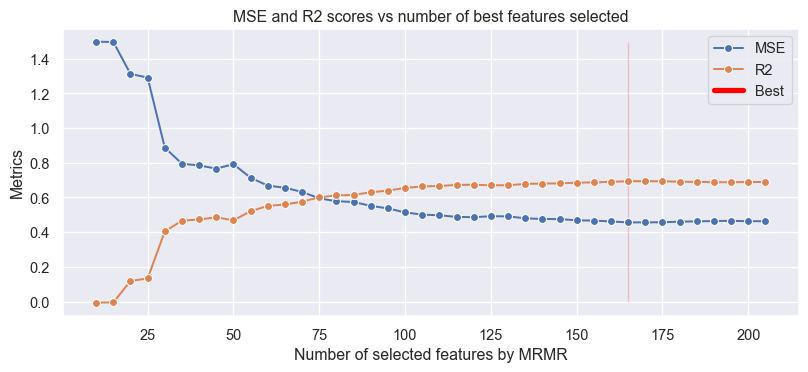

In [44]:
mse, r2 = plot_reg_fs_metrics(num_sel_feat, results, "MRMR")

In [ ]:
# Take selected features by MRMR
selected_features_mrmr = features[np.argmax(r2)]

Best performance occurs when the number of selected features is **165**. Once again, model that better performs is **SVR**, with the following metrics: **R2: 0.693, MAE: 0.502, MSE: 0.456**. This means there is a **0.05** improvement in the R2 score while using **43** features less.

#### Perform Hyper parameter optimisation using randomizedSearchCV() with SVR as its the best performing baseline model

In [ ]:
rnd_models_mrmr, metrics_rnd_mrmr = apply_randsearch(X_train[selected_features_mrmr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mrmr]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mrmr]
                                                        , X_val_norm[selected_features_mrmr])

In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, 'SVR-MRMR', 0.748425, True)

### 2 - Improving the model: Feature Selection - Relieff 

In [27]:
n_neighbors = 100
models_relief, results_relief, num_sel_feat_relief, features_relief = fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, n_neighbors)


=======================Selected features 10/207 =======================
RFR | R2: 0.531, MAE: 0.629, MSE: 0.698
DTR | R2: 0.099, MAE: 0.841, MSE: 1.342
SVR | R2: 0.508, MAE: 0.656, MSE: 0.732
MLPR | R2: 0.476, MAE: 0.655, MSE: 0.781
XGBR | R2: 0.496, MAE: 0.646, MSE: 0.750

=======================Selected features 15/207 =======================
RFR | R2: 0.573, MAE: 0.607, MSE: 0.636
DTR | R2: 0.138, MAE: 0.832, MSE: 1.283
SVR | R2: 0.562, MAE: 0.610, MSE: 0.652
MLPR | R2: 0.482, MAE: 0.656, MSE: 0.771
XGBR | R2: 0.564, MAE: 0.612, MSE: 0.649

=======================Selected features 20/207 =======================
RFR | R2: 0.591, MAE: 0.588, MSE: 0.609
DTR | R2: 0.257, MAE: 0.784, MSE: 1.105
SVR | R2: 0.595, MAE: 0.586, MSE: 0.602
MLPR | R2: 0.501, MAE: 0.642, MSE: 0.743
XGBR | R2: 0.588, MAE: 0.583, MSE: 0.614

=======================Selected features 25/207 =======================
RFR | R2: 0.594, MAE: 0.580, MSE: 0.604
DTR | R2: 0.149, MAE: 0.825, MSE: 1.267
SVR | R2: 0.609, MAE: 

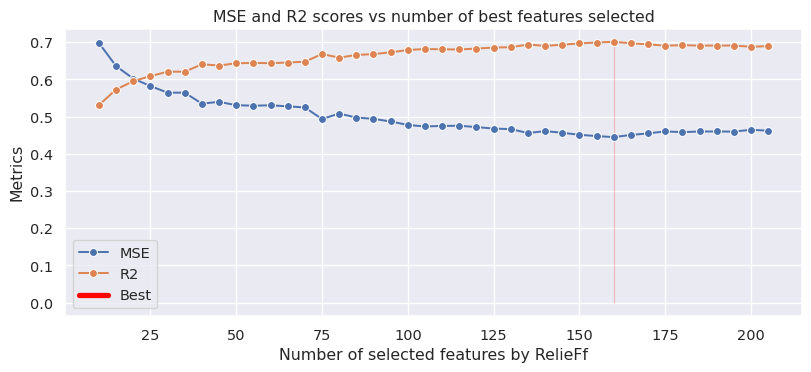

In [28]:
mse_relieff, r2_relieff = plot_reg_fs_metrics(num_sel_feat_relief, results_relief, "RelieFf")

In [29]:
# Selected features by RelieFf algorithm
selected_features_relieff = features_relief[np.argmax(r2_relieff)]

In [30]:
# Apply randsearch to the potential model candidates with the selected features
rnd_models_relieff, metrics_rnd_relieff = apply_randsearch(X_train[selected_features_relieff]
                                                        , y_train                                                       
                                                        , X_val[selected_features_relieff]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_relieff]
                                                        , X_val_norm[selected_features_relieff])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.753213, mse: 0.367328, mae: 0.446254


In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, 'SVR-RELIEFF', 0.753213, True)

### 3 - Improving the model: Feature Selection - Mutual_info_regression

This method utilizes the mutual information. It calculates mutual information value for each of independent variables with respect to dependent variable, and selects the ones which has most information gain. In other words, it basically measures the dependency of features with the target value. The higher score means more dependent variables.

In [32]:
# Apply feature selection using mutual_info_regression
models_mir, results_mir, num_sel_feat_mir,features_mir = fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, mutual_info_regression)


=======================Selected features 10/207 =======================
RFR | R2: 0.582, MAE: 0.593, MSE: 0.622
DTR | R2: 0.274, MAE: 0.770, MSE: 1.080
SVR | R2: 0.436, MAE: 0.710, MSE: 0.839
MLPR | R2: 0.354, MAE: 0.721, MSE: 0.961
XGBR | R2: 0.560, MAE: 0.602, MSE: 0.654

=======================Selected features 15/207 =======================
RFR | R2: 0.589, MAE: 0.586, MSE: 0.612
DTR | R2: 0.228, MAE: 0.799, MSE: 1.149
SVR | R2: 0.501, MAE: 0.667, MSE: 0.742
MLPR | R2: 0.320, MAE: 0.732, MSE: 1.013
XGBR | R2: 0.569, MAE: 0.601, MSE: 0.642

=======================Selected features 20/207 =======================
RFR | R2: 0.604, MAE: 0.582, MSE: 0.589
DTR | R2: 0.265, MAE: 0.776, MSE: 1.094
SVR | R2: 0.589, MAE: 0.595, MSE: 0.612
MLPR | R2: 0.487, MAE: 0.634, MSE: 0.763
XGBR | R2: 0.629, MAE: 0.555, MSE: 0.552

=======================Selected features 25/207 =======================
RFR | R2: 0.623, MAE: 0.565, MSE: 0.561
DTR | R2: 0.301, MAE: 0.746, MSE: 1.041
SVR | R2: 0.618, MAE: 

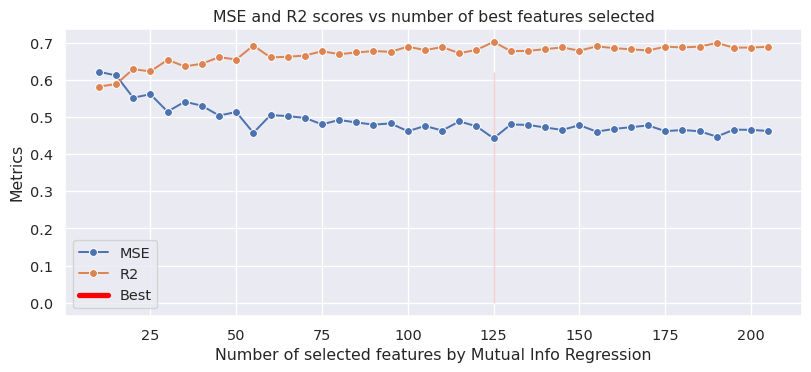

In [33]:
# Plot scores obtained
mse_mir, r2_mir = plot_reg_fs_metrics(num_sel_feat_mir, results_mir, "Mutual Info Regression")

In [34]:
# Selected features by MIR algorithm
selected_features_mir = features_mir[np.argmax(r2_mir)]

In [35]:
# Apply randsearch to the potential model candidates with the selected features
rnd_models_mir, metrics_rnd_mir = apply_randsearch(X_train[selected_features_mir]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mir]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mir]
                                                        , X_val_norm[selected_features_mir])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.736764, mse: 0.391812, mae: 0.461887


In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, 'SVR-MIR', 0.736764, True)

### 4 - Improving the model: Manual data cleaning

#### Pipeline
- Remove **MolLogP** and **BCUT2D** features. 
- Remove **zero variance features**. 
- Remove **high correlated** features.

#### 1 - Remove MolLogP, BCUT2D, and zero variance features. 

In [36]:
#Remove MolLogP, BCUT2D, and features with zero variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selector.fit(X_train)

# Selector.get_support() returns a [,num_descriptors] boolean mask. False represents zero variance columns.
zero_var_cols = [column for column in X_train.columns
                    if column not in X_train.columns[selector.get_support()]]

print('There are {} columns with zero variance'.format(len(zero_var_cols)))

# As BCUT features and MolLogP may have counterproductive effects, we proceed to delete them
zero_var_cols.extend([col for col in df.columns if 'BCUT2D' in col or 'MolLogP' in col])

print('Total number of features dropped:', len(zero_var_cols))

There are 10 columns with zero variance
Total number of features dropped: 19


#### 2 - Remove high correlated features

In [37]:
# We drop the features with a high correlation

corr = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than X
correlated_features = [col for col in upper.columns if any(upper[col] > 0.95)]

print('Number of correlated features deleted: {}'.format(len(correlated_features)))

Number of correlated features deleted: 29


In [38]:
# We group all the dropped features
mc_cols = list(set(X_train.columns) - set(correlated_features + zero_var_cols))

print('Total number of remaining descriptors after the data cleaning: {}'.format(len(mc_cols)))

Total number of remaining descriptors after the data cleaning: 159


### Models comparison after data cleaning

RFR | R2: 0.603, MAE: 0.580, MSE: 0.591
DTR | R2: 0.159, MAE: 0.828, MSE: 1.252
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.602, MAE: 0.556, MSE: 0.592
XGBR | R2: 0.636, MAE: 0.538, MSE: 0.542


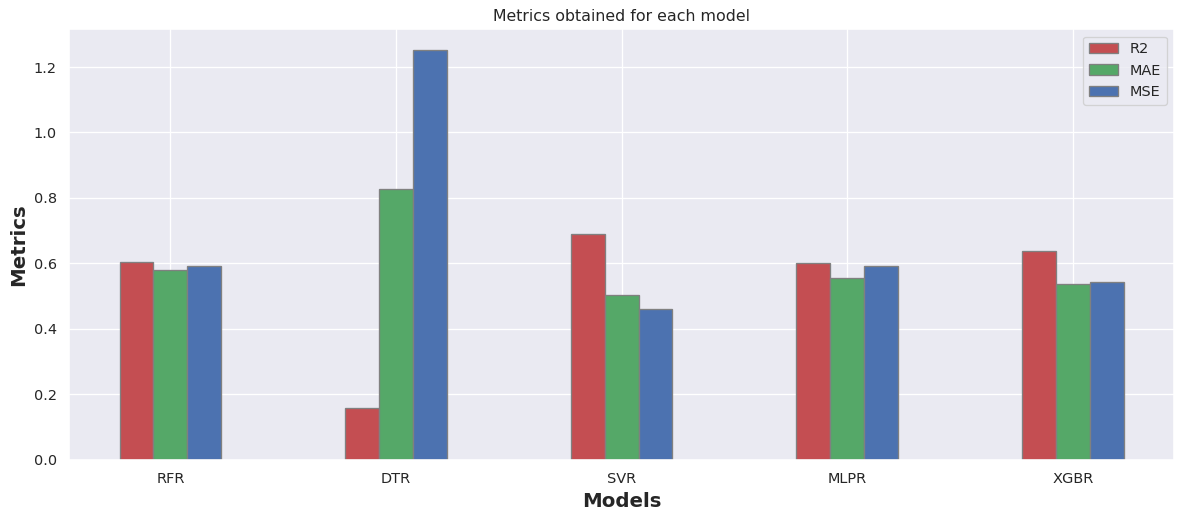

In [39]:
models, results = models_comparison(X_train[mc_cols]
                                    , y_train
                                    , X_val[mc_cols]
                                    , y_val
                                    , False
                                    , True
                                    , False
                                    , X_train_norm[mc_cols]
                                    , X_val_norm[mc_cols])

In [40]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

In [41]:
rnd_models_mc, metrics_rnd_mc = apply_randsearch(X_train[mc_cols]
                                                        , y_train                                                       
                                                        , X_val[mc_cols]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[mc_cols]
                                                        , X_val_norm[mc_cols])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.743075, mse: 0.382419, mae: 0.447705


In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, 'SVR-MCr', 0.743075)

### Exploring alternatives: RandomizedSearchCV() in potential candidates

By making use of RandomizedSearchCV() we could perhaps obtain better metrics in our potential model candidates  SVR and RFR. Function combines the given hyperparameters randomly to come up with the best tuning. 

In [42]:
#rnd_models, metrics = apply_randsearch(X_train, X_train_norm, y_train, X_val, False, X_val_norm, y_val)

In [52]:
# Added 
# Once hyper parameter tuning is done apply Relief FS algo on pre-processed/cleaned dataset

models_sel, results_sel, num_sel_feat_sel, features_sel = fs_relieff_selected_features(X_train[mc_cols], y_train, X_val[mc_cols], y_val, X_train_norm[mc_cols], X_val_norm[mc_cols], False, n_neighbors)



=======================Selected features 30/159 =======================
RFR | R2: 0.582, MAE: 0.597, MSE: 0.623
DTR | R2: 0.107, MAE: 0.839, MSE: 1.330
SVR | R2: 0.617, MAE: 0.566, MSE: 0.571
MLPR | R2: 0.481, MAE: 0.644, MSE: 0.773
XGBR | R2: 0.547, MAE: 0.606, MSE: 0.674

=======================Selected features 60/159 =======================
RFR | R2: 0.595, MAE: 0.581, MSE: 0.603
DTR | R2: 0.113, MAE: 0.822, MSE: 1.320
SVR | R2: 0.661, MAE: 0.524, MSE: 0.505
MLPR | R2: 0.587, MAE: 0.581, MSE: 0.615
XGBR | R2: 0.612, MAE: 0.570, MSE: 0.578

=======================Selected features 90/159 =======================
RFR | R2: 0.599, MAE: 0.583, MSE: 0.598
DTR | R2: 0.213, MAE: 0.797, MSE: 1.171
SVR | R2: 0.677, MAE: 0.510, MSE: 0.480
MLPR | R2: 0.614, MAE: 0.554, MSE: 0.574
XGBR | R2: 0.590, MAE: 0.586, MSE: 0.611

=======================Selected features 120/159 =======================
RFR | R2: 0.600, MAE: 0.582, MSE: 0.596
DTR | R2: 0.158, MAE: 0.824, MSE: 1.253
SVR | R2: 0.703, MAE:

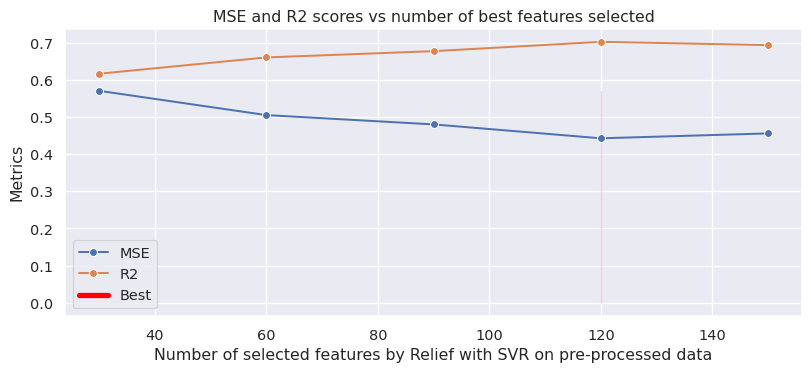

In [57]:
# Added
mse_sel, r2_sel = plot_regression_metrics_reduced_features(X_train[mc_cols], num_sel_feat_sel, results_sel, "Relief with SVR on pre-processed data")

In [77]:
# Save the model 
joblib.dump(rnd_models_mrmr[0], 'optimised_svr_mrmr.pkl')
joblib.dump(rnd_models_relieff[0], 'optimised_svr_relieff.pkl')
joblib.dump(rnd_models_mir[0], 'optimised_svr_mir.pkl')
joblib.dump(rnd_models_mc[0], 'clean.pkl')
joblib.dump(models_sel[0], 'clean_optimised_svr_relief.pkl')


# Loading model
opt_svr_mrmr = joblib.load('optimised_svr_mrmr.pkl')
opt_svr_relieff = joblib.load('optimised_svr_relieff.pkl')
opt_svr_mir = joblib.load('optimised_svr_mir.pkl')
clean = joblib.load('clean.pkl')
clean_opt_svr_relief = joblib.load('clean_optimised_svr_relief.pkl')

# Ames mutagenicity 
Mutagenicity means the ability of a drug to induce genetic alterations. Drugs that can cause damage to the DNA can result in cell death or other severe adverse effects

In [109]:
data = Tox(name = 'AMES')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_AMES = data.get_split()

Found local copy...
Loading...
Done!


In [110]:
data_overview(df, split_AMES)

Total number of molecules: 7278
Train set: 5094 - 70.0%
Validation set: 728 - 10.0%
Test set: 1456 - 20.0%


,Drug_ID,Drug,Y
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1


In [6]:
# Remove fragments of compounds that may contain them
#frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
#for ind, c in enumerate(frag_compounds):
#    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

#print('Number of compounds modified:{}'.format(len(frag_compounds)))

In [111]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
New number of compounds: 7140 (-138)


In [112]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (Ames) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (7140, 211)


In [113]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310,332.230,342.064057,124.0,0.0,0.277383,-0.258290,0.277383,0.258290,0.538462,0.923077,1.307692,16.631769,9.878024,2.243219,-2.142638,2.460575,-1.957799,6.364064,-0.382738,2.267149,1284.790209,17.999271,13.300923,13.300923,12.575387,7.986911,7.986911,6.240968,6.240968,4.982737,4.982737,3.980293,3.980293,-3.80,1.358228e+06,14.535237,4.857510,1.699174,145.443038,0.000000,0.000000,0.000000,0.0,11.374773,0.000000,20.228637,0.000000,0.000000,0.0,36.398202,33.677631,22.905183,20.619071,9.846622,54.464566,0.0,0.000000,0.000000,0.000000,0.000000,80.892307,0.0,0.0,0.000000,11.374773,0.0,0.0,9.846622,0.000000,20.228637,0.000000,60.663671,0.0,43.089794,0.0,86.28,9.846622,20.228637,0.0,11.374773,32.317345,10.772448,12.132734,36.398202,12.132734,0.000000,0.000000,0.0,0.0,22.534604,28.751336,0.017789,0.000000,17.362937,0.000000,0.000000,0.0,0.00,26.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,6.0,2.0,0.0,0.0,0.0,5.0,5.5536,100.9608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,11.824743,-0.170602,11.824743,0.170602,0.269289,301.345,286.225,301.110279,112

In [114]:
# Generate fingerprints dataset and transform into a dataframe
fingerprints = generate_fingerprints(df)
fps = pd.DataFrame(fingerprints, columns = np.arange(1,1025))

Current shape of the fingerprint dataset: 7140 x 1024


In [115]:
X_train, X_train_fps, y_train, X_val, X_val_fps, y_val, X_test, X_test_fps, y_test = train_val_test_split(df, split_AMES, fps)

Data has been split


In [116]:
X_train, X_train_fps, y_train, X_val, X_val_fps, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps)

Removed the following rows in the train set: Int64Index([231, 3258, 3693], dtype='int64')
Removed the following rows in the val set: Int64Index([5482], dtype='int64')
Removed the following rows in the test set: Int64Index([6439], dtype='int64')


In [117]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


### Check balance of dataset/split

## Building our baseline models

MLPC | MCC: 0.524, AUC: 0.762, Accuracy: 0.749, Precision: 0.772, Recall: 0.762
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.728, Precision: 0.769, Recall: 0.747
[22:14:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.582, AUC: 0.791, Accuracy: 0.777, Precision: 0.803, Recall: 0.791


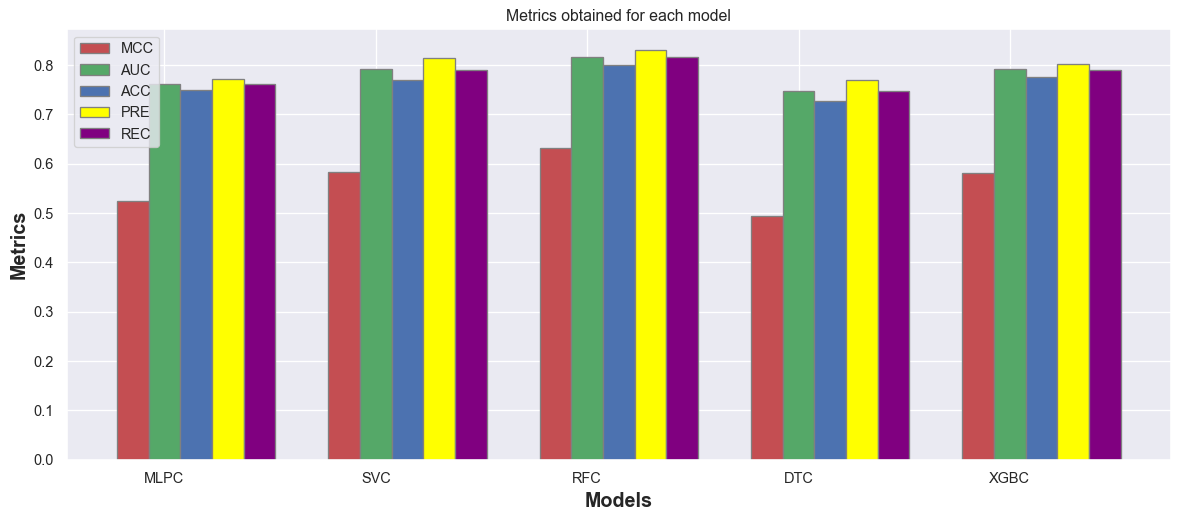

In [119]:
models, results = models_comparison(X_train, y_train, X_val, y_val, True,True, False, X_train_norm, X_val_norm)

In [122]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


MLPC | MCC: 0.425, AUC: 0.712, Accuracy: 0.711, Precision: 0.693, Recall: 0.713
SVC | MCC: 0.428, AUC: 0.714, Accuracy: 0.705, Precision: 0.713, Recall: 0.714
RFC | MCC: 0.409, AUC: 0.705, Accuracy: 0.689, Precision: 0.718, Recall: 0.704
DTC | MCC: 0.327, AUC: 0.664, Accuracy: 0.646, Precision: 0.687, Recall: 0.663
[22:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.43it/s]


MLPC | MCC: 0.464, AUC: 0.732, Accuracy: 0.716, Precision: 0.746, Recall: 0.732
SVC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
RFC | MCC: 0.489, AUC: 0.744, Accuracy: 0.730, Precision: 0.755, Recall: 0.744
DTC | MCC: 0.339, AUC: 0.669, Accuracy: 0.640, Precision: 0.730, Recall: 0.667
[22:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.468, AUC: 0.734, Accuracy: 0.714, Precision: 0.758, Recall: 0.733


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


MLPC | MCC: 0.500, AUC: 0.750, Accuracy: 0.736, Precision: 0.761, Recall: 0.750
SVC | MCC: 0.467, AUC: 0.733, Accuracy: 0.719, Precision: 0.744, Recall: 0.733
RFC | MCC: 0.550, AUC: 0.775, Accuracy: 0.753, Precision: 0.800, Recall: 0.774
DTC | MCC: 0.411, AUC: 0.705, Accuracy: 0.682, Precision: 0.738, Recall: 0.704
[22:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.523, AUC: 0.761, Accuracy: 0.740, Precision: 0.786, Recall: 0.761


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s]


MLPC | MCC: 0.517, AUC: 0.758, Accuracy: 0.725, Precision: 0.808, Recall: 0.757
SVC | MCC: 0.505, AUC: 0.752, Accuracy: 0.725, Precision: 0.789, Recall: 0.751
RFC | MCC: 0.576, AUC: 0.788, Accuracy: 0.780, Precision: 0.789, Recall: 0.788
DTC | MCC: 0.388, AUC: 0.694, Accuracy: 0.673, Precision: 0.724, Recall: 0.693
[22:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.533, AUC: 0.767, Accuracy: 0.747, Precision: 0.789, Recall: 0.766


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.28it/s]


MLPC | MCC: 0.501, AUC: 0.750, Accuracy: 0.727, Precision: 0.780, Recall: 0.750
SVC | MCC: 0.536, AUC: 0.768, Accuracy: 0.747, Precision: 0.792, Recall: 0.768
RFC | MCC: 0.587, AUC: 0.794, Accuracy: 0.786, Precision: 0.794, Recall: 0.794
DTC | MCC: 0.407, AUC: 0.703, Accuracy: 0.683, Precision: 0.730, Recall: 0.703
[22:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.546, AUC: 0.773, Accuracy: 0.745, Precision: 0.808, Recall: 0.772


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.53it/s]


MLPC | MCC: 0.536, AUC: 0.766, Accuracy: 0.727, Precision: 0.831, Recall: 0.765
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.745, Precision: 0.792, Recall: 0.766
RFC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802
DTC | MCC: 0.400, AUC: 0.700, Accuracy: 0.674, Precision: 0.741, Recall: 0.699
[22:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.576, AUC: 0.788, Accuracy: 0.762, Precision: 0.820, Recall: 0.787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.30it/s]


MLPC | MCC: 0.489, AUC: 0.744, Accuracy: 0.729, Precision: 0.758, Recall: 0.744
SVC | MCC: 0.529, AUC: 0.764, Accuracy: 0.738, Precision: 0.800, Recall: 0.763
RFC | MCC: 0.593, AUC: 0.797, Accuracy: 0.785, Precision: 0.803, Recall: 0.796
DTC | MCC: 0.498, AUC: 0.749, Accuracy: 0.728, Precision: 0.775, Recall: 0.748
[22:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.531, AUC: 0.765, Accuracy: 0.732, Precision: 0.814, Recall: 0.763


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]


MLPC | MCC: 0.537, AUC: 0.768, Accuracy: 0.742, Precision: 0.803, Recall: 0.768
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.743, Precision: 0.797, Recall: 0.766
RFC | MCC: 0.593, AUC: 0.796, Accuracy: 0.790, Precision: 0.794, Recall: 0.796
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.558, AUC: 0.779, Accuracy: 0.758, Precision: 0.803, Recall: 0.779


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.62it/s]


MLPC | MCC: 0.546, AUC: 0.773, Accuracy: 0.743, Precision: 0.814, Recall: 0.772
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.742, Precision: 0.800, Recall: 0.766
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806
DTC | MCC: 0.460, AUC: 0.730, Accuracy: 0.706, Precision: 0.763, Recall: 0.729
[22:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.563, AUC: 0.781, Accuracy: 0.751, Precision: 0.823, Recall: 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:15<00:00,  3.44it/s]


MLPC | MCC: 0.558, AUC: 0.779, Accuracy: 0.764, Precision: 0.792, Recall: 0.779
SVC | MCC: 0.524, AUC: 0.762, Accuracy: 0.734, Precision: 0.800, Recall: 0.761
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.801, Precision: 0.837, Recall: 0.818
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.706, Precision: 0.744, Recall: 0.724
[22:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.03it/s]


MLPC | MCC: 0.540, AUC: 0.770, Accuracy: 0.744, Precision: 0.803, Recall: 0.769
SVC | MCC: 0.530, AUC: 0.764, Accuracy: 0.735, Precision: 0.806, Recall: 0.763
RFC | MCC: 0.596, AUC: 0.798, Accuracy: 0.784, Precision: 0.808, Recall: 0.798
DTC | MCC: 0.474, AUC: 0.737, Accuracy: 0.712, Precision: 0.772, Recall: 0.736
[22:24:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.764, Precision: 0.820, Recall: 0.788


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:20<00:00,  3.24it/s]


MLPC | MCC: 0.537, AUC: 0.769, Accuracy: 0.769, Precision: 0.752, Recall: 0.769
SVC | MCC: 0.522, AUC: 0.760, Accuracy: 0.730, Precision: 0.806, Recall: 0.759
RFC | MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824
DTC | MCC: 0.527, AUC: 0.763, Accuracy: 0.753, Precision: 0.766, Recall: 0.763
[22:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.779, Precision: 0.814, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.47it/s]


MLPC | MCC: 0.548, AUC: 0.774, Accuracy: 0.749, Precision: 0.806, Recall: 0.773
SVC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.800, Precision: 0.834, Recall: 0.817
DTC | MCC: 0.453, AUC: 0.727, Accuracy: 0.711, Precision: 0.741, Recall: 0.726
[22:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.584, AUC: 0.792, Accuracy: 0.764, Precision: 0.828, Recall: 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.24it/s]


MLPC | MCC: 0.587, AUC: 0.794, Accuracy: 0.784, Precision: 0.797, Recall: 0.794
SVC | MCC: 0.551, AUC: 0.775, Accuracy: 0.748, Precision: 0.811, Recall: 0.774
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.796, Precision: 0.823, Recall: 0.810
DTC | MCC: 0.441, AUC: 0.721, Accuracy: 0.713, Precision: 0.715, Recall: 0.721
[22:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.781, Precision: 0.823, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.45it/s]


MLPC | MCC: 0.552, AUC: 0.774, Accuracy: 0.735, Precision: 0.837, Recall: 0.773
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.450, AUC: 0.725, Accuracy: 0.715, Precision: 0.727, Recall: 0.725
[22:26:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.784, Precision: 0.806, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:25<00:00,  3.38it/s]


MLPC | MCC: 0.574, AUC: 0.786, Accuracy: 0.745, Precision: 0.848, Recall: 0.784
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.798, Precision: 0.814, Recall: 0.809
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.714, Precision: 0.732, Recall: 0.726
[22:27:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.607, AUC: 0.804, Accuracy: 0.788, Precision: 0.817, Recall: 0.803


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:26<00:00,  3.37it/s]


MLPC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
SVC | MCC: 0.545, AUC: 0.771, Accuracy: 0.739, Precision: 0.820, Recall: 0.770
RFC | MCC: 0.623, AUC: 0.812, Accuracy: 0.798, Precision: 0.823, Recall: 0.812
DTC | MCC: 0.462, AUC: 0.731, Accuracy: 0.714, Precision: 0.746, Recall: 0.730
[22:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:27<00:00,  3.50it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.769, Precision: 0.806, Recall: 0.787
SVC | MCC: 0.547, AUC: 0.773, Accuracy: 0.740, Precision: 0.820, Recall: 0.772
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[22:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.597, AUC: 0.798, Accuracy: 0.775, Precision: 0.825, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


MLPC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801
SVC | MCC: 0.539, AUC: 0.769, Accuracy: 0.736, Precision: 0.817, Recall: 0.768
RFC | MCC: 0.621, AUC: 0.811, Accuracy: 0.791, Precision: 0.831, Recall: 0.810
DTC | MCC: 0.476, AUC: 0.738, Accuracy: 0.715, Precision: 0.769, Recall: 0.737
[22:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.768, Precision: 0.811, Recall: 0.788


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:30<00:00,  3.49it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.775, Precision: 0.794, Recall: 0.787
SVC | MCC: 0.563, AUC: 0.781, Accuracy: 0.752, Precision: 0.820, Recall: 0.780
RFC | MCC: 0.643, AUC: 0.822, Accuracy: 0.803, Precision: 0.839, Recall: 0.821
DTC | MCC: 0.507, AUC: 0.753, Accuracy: 0.727, Precision: 0.789, Recall: 0.752
[22:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.613, AUC: 0.806, Accuracy: 0.774, Precision: 0.848, Recall: 0.805


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:30<00:00,  3.61it/s]


MLPC | MCC: 0.557, AUC: 0.778, Accuracy: 0.787, Precision: 0.749, Recall: 0.779
SVC | MCC: 0.554, AUC: 0.777, Accuracy: 0.750, Precision: 0.811, Recall: 0.776
RFC | MCC: 0.647, AUC: 0.823, Accuracy: 0.797, Precision: 0.854, Recall: 0.823
DTC | MCC: 0.479, AUC: 0.739, Accuracy: 0.715, Precision: 0.772, Recall: 0.739
[22:31:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.770, Precision: 0.828, Recall: 0.795


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:30<00:00,  3.74it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.788, Precision: 0.797, Recall: 0.796
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.759, Precision: 0.814, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.804, Precision: 0.823, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[22:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:30<00:00,  3.89it/s]


MLPC | MCC: 0.559, AUC: 0.778, Accuracy: 0.744, Precision: 0.828, Recall: 0.777
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.801, Precision: 0.839, Recall: 0.820
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[22:33:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.603, AUC: 0.801, Accuracy: 0.776, Precision: 0.831, Recall: 0.801


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:30<00:00,  4.09it/s]


MLPC | MCC: 0.535, AUC: 0.767, Accuracy: 0.763, Precision: 0.761, Recall: 0.768
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.794, Precision: 0.814, Recall: 0.806
DTC | MCC: 0.477, AUC: 0.738, Accuracy: 0.714, Precision: 0.772, Recall: 0.737
[22:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.779, Precision: 0.834, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:31<00:00,  4.14it/s]


MLPC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.616, AUC: 0.808, Accuracy: 0.787, Precision: 0.831, Recall: 0.807
DTC | MCC: 0.480, AUC: 0.740, Accuracy: 0.712, Precision: 0.780, Recall: 0.739
[22:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:31<00:00,  4.33it/s]


MLPC | MCC: 0.545, AUC: 0.772, Accuracy: 0.751, Precision: 0.797, Recall: 0.772
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.780, Precision: 0.811, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:32<00:00,  4.33it/s]


MLPC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.797, Precision: 0.820, Recall: 0.810
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.713, Precision: 0.735, Recall: 0.726
[22:36:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.775, Precision: 0.823, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:32<00:00,  4.43it/s]


MLPC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.798, Precision: 0.845, Recall: 0.820
DTC | MCC: 0.407, AUC: 0.704, Accuracy: 0.682, Precision: 0.732, Recall: 0.703
[22:37:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.64it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.586, AUC: 0.793, Accuracy: 0.771, Precision: 0.817, Recall: 0.792
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.812, Precision: 0.814, Recall: 0.817
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.704, Precision: 0.749, Recall: 0.724
[22:38:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.596, AUC: 0.798, Accuracy: 0.780, Precision: 0.817, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:33<00:00,  4.66it/s]


MLPC | MCC: 0.615, AUC: 0.808, Accuracy: 0.791, Precision: 0.823, Recall: 0.807
SVC | MCC: 0.580, AUC: 0.790, Accuracy: 0.769, Precision: 0.814, Recall: 0.790
RFC | MCC: 0.629, AUC: 0.815, Accuracy: 0.799, Precision: 0.828, Recall: 0.814
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[22:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.595, AUC: 0.797, Accuracy: 0.769, Precision: 0.834, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:33<00:00,  4.75it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.773, Precision: 0.794, Recall: 0.785
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.467, AUC: 0.733, Accuracy: 0.718, Precision: 0.746, Recall: 0.733
[22:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.785, Precision: 0.811, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:33<00:00,  4.92it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.768, Precision: 0.831, Recall: 0.795
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.646, AUC: 0.823, Accuracy: 0.804, Precision: 0.842, Recall: 0.823
DTC | MCC: 0.414, AUC: 0.707, Accuracy: 0.693, Precision: 0.718, Recall: 0.707
[22:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.786, Precision: 0.808, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:34<00:00,  4.89it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.570, AUC: 0.785, Accuracy: 0.761, Precision: 0.814, Recall: 0.784
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.797, Precision: 0.842, Recall: 0.818
DTC | MCC: 0.457, AUC: 0.728, Accuracy: 0.707, Precision: 0.755, Recall: 0.728
[22:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.800, Accuracy: 0.783, Precision: 0.814, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:34<00:00,  5.10it/s]


MLPC | MCC: 0.580, AUC: 0.790, Accuracy: 0.772, Precision: 0.808, Recall: 0.790
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.649, AUC: 0.824, Accuracy: 0.806, Precision: 0.842, Recall: 0.824
DTC | MCC: 0.470, AUC: 0.735, Accuracy: 0.720, Precision: 0.746, Recall: 0.735
[22:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:34<00:00,  5.16it/s]


MLPC | MCC: 0.571, AUC: 0.785, Accuracy: 0.779, Precision: 0.783, Recall: 0.785
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.761, Precision: 0.808, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.803, Precision: 0.825, Recall: 0.816
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725
[22:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:33<00:00,  5.46it/s]


MLPC | MCC: 0.579, AUC: 0.789, Accuracy: 0.761, Precision: 0.825, Recall: 0.788
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.803, Precision: 0.828, Recall: 0.817
DTC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
[22:44:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.782, Precision: 0.828, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:34<00:00,  5.56it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.770, Precision: 0.800, Recall: 0.785
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.475, AUC: 0.737, Accuracy: 0.724, Precision: 0.746, Recall: 0.737
[22:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.616, AUC: 0.808, Accuracy: 0.785, Precision: 0.834, Recall: 0.807


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:34<00:00,  5.64it/s]


MLPC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784
SVC | MCC: 0.583, AUC: 0.792, Accuracy: 0.769, Precision: 0.817, Recall: 0.791
RFC | MCC: 0.640, AUC: 0.820, Accuracy: 0.806, Precision: 0.831, Recall: 0.820
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.706, Precision: 0.749, Recall: 0.725
[22:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.60it/s]


MLPC | MCC: 0.588, AUC: 0.794, Accuracy: 0.776, Precision: 0.811, Recall: 0.794
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.767, Precision: 0.808, Recall: 0.787
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809
DTC | MCC: 0.497, AUC: 0.748, Accuracy: 0.718, Precision: 0.794, Recall: 0.747
[22:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:40<00:00,  4.97it/s]


MLPC | MCC: 0.598, AUC: 0.799, Accuracy: 0.798, Precision: 0.789, Recall: 0.799
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.652, AUC: 0.826, Accuracy: 0.805, Precision: 0.848, Recall: 0.825
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.698, Precision: 0.769, Recall: 0.725
[22:48:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.790, Precision: 0.828, Recall: 0.809


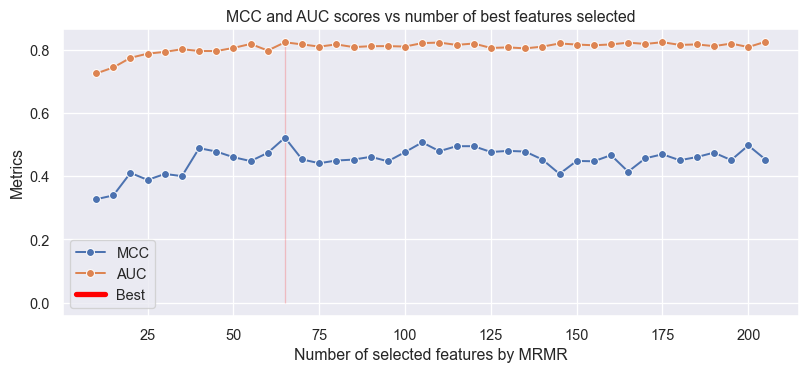

In [138]:
mcc, auc = plot_classification_metrics(results, X_train)

Best performance occurs when the number of selected features is **65**. In this case, the model that better performs is **RFC**, with the following metrics: **MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824**. This means there is a **0.16** improvement in the MCC score while using **143** less features.

In [125]:
# Take selected features by MRMR
selected_features_mrmr = features[np.argmax(mcc)]

### Added: Classification for Ames dataset

### Train, validation, and test sets for both Descriptors 


In [127]:
df_ames=df

In [128]:
X_train, X_train_desc, y_train, X_val, X_val_desc, y_val, X_test, X_test_desc, y_test = train_val_test_split(df_ames, split_AMES, df)

Data has been split


### Remove NaNs

In [129]:
X_train, X_train_desc, y_train, X_val, X_val_desc, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_desc, X_val_desc)

Removed the following rows in the train set: Int64Index([231, 3258, 3693], dtype='int64')
Removed the following rows in the val set: Int64Index([5482], dtype='int64')
Removed the following rows in the test set: Int64Index([6439], dtype='int64')


### Data normalization is required in linear models

In [130]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


### Check data balance across both the labels

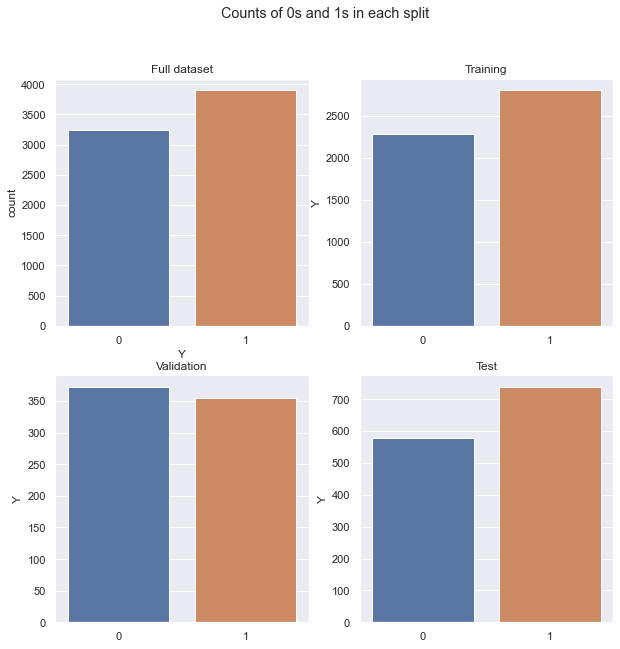

In [131]:
#check_data_balance(df_ames, y_train, y_val, y_test)

### Building Baseline models for descriptors

MLPC | MCC: 0.524, AUC: 0.762, Accuracy: 0.749, Precision: 0.772, Recall: 0.762
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.728, Precision: 0.769, Recall: 0.747
[22:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.582, AUC: 0.791, Accuracy: 0.777, Precision: 0.803, Recall: 0.791


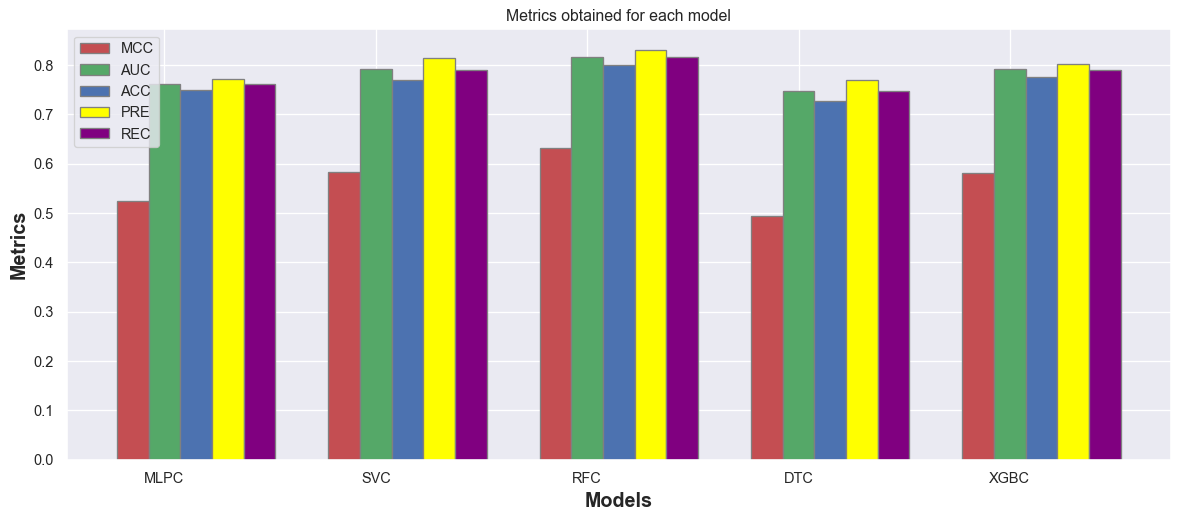

In [132]:
models_desc, results_desc = models_comparison(X_train, y_train, X_val, y_val, True,True, False, X_train_norm, X_val_norm)

In [133]:
models_mrmr, results_mrmr, num_sel_feat_mrmr, features_mrmr = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


MLPC | MCC: 0.425, AUC: 0.712, Accuracy: 0.711, Precision: 0.693, Recall: 0.713
SVC | MCC: 0.428, AUC: 0.714, Accuracy: 0.705, Precision: 0.713, Recall: 0.714
RFC | MCC: 0.409, AUC: 0.705, Accuracy: 0.689, Precision: 0.718, Recall: 0.704
DTC | MCC: 0.327, AUC: 0.664, Accuracy: 0.646, Precision: 0.687, Recall: 0.663
[22:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]


MLPC | MCC: 0.464, AUC: 0.732, Accuracy: 0.716, Precision: 0.746, Recall: 0.732
SVC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
RFC | MCC: 0.489, AUC: 0.744, Accuracy: 0.730, Precision: 0.755, Recall: 0.744
DTC | MCC: 0.339, AUC: 0.669, Accuracy: 0.640, Precision: 0.730, Recall: 0.667
[22:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.468, AUC: 0.734, Accuracy: 0.714, Precision: 0.758, Recall: 0.733


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.96it/s]


MLPC | MCC: 0.500, AUC: 0.750, Accuracy: 0.736, Precision: 0.761, Recall: 0.750
SVC | MCC: 0.467, AUC: 0.733, Accuracy: 0.719, Precision: 0.744, Recall: 0.733
RFC | MCC: 0.550, AUC: 0.775, Accuracy: 0.753, Precision: 0.800, Recall: 0.774
DTC | MCC: 0.411, AUC: 0.705, Accuracy: 0.682, Precision: 0.738, Recall: 0.704
[22:53:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.523, AUC: 0.761, Accuracy: 0.740, Precision: 0.786, Recall: 0.761


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.90it/s]


MLPC | MCC: 0.517, AUC: 0.758, Accuracy: 0.725, Precision: 0.808, Recall: 0.757
SVC | MCC: 0.505, AUC: 0.752, Accuracy: 0.725, Precision: 0.789, Recall: 0.751
RFC | MCC: 0.576, AUC: 0.788, Accuracy: 0.780, Precision: 0.789, Recall: 0.788
DTC | MCC: 0.388, AUC: 0.694, Accuracy: 0.673, Precision: 0.724, Recall: 0.693
[22:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.533, AUC: 0.767, Accuracy: 0.747, Precision: 0.789, Recall: 0.766


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]


MLPC | MCC: 0.501, AUC: 0.750, Accuracy: 0.727, Precision: 0.780, Recall: 0.750
SVC | MCC: 0.536, AUC: 0.768, Accuracy: 0.747, Precision: 0.792, Recall: 0.768
RFC | MCC: 0.587, AUC: 0.794, Accuracy: 0.786, Precision: 0.794, Recall: 0.794
DTC | MCC: 0.407, AUC: 0.703, Accuracy: 0.683, Precision: 0.730, Recall: 0.703
[22:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.546, AUC: 0.773, Accuracy: 0.745, Precision: 0.808, Recall: 0.772


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.14it/s]


MLPC | MCC: 0.536, AUC: 0.766, Accuracy: 0.727, Precision: 0.831, Recall: 0.765
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.745, Precision: 0.792, Recall: 0.766
RFC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802
DTC | MCC: 0.400, AUC: 0.700, Accuracy: 0.674, Precision: 0.741, Recall: 0.699
[22:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.576, AUC: 0.788, Accuracy: 0.762, Precision: 0.820, Recall: 0.787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.38it/s]


MLPC | MCC: 0.489, AUC: 0.744, Accuracy: 0.729, Precision: 0.758, Recall: 0.744
SVC | MCC: 0.529, AUC: 0.764, Accuracy: 0.738, Precision: 0.800, Recall: 0.763
RFC | MCC: 0.593, AUC: 0.797, Accuracy: 0.785, Precision: 0.803, Recall: 0.796
DTC | MCC: 0.498, AUC: 0.749, Accuracy: 0.728, Precision: 0.775, Recall: 0.748
[22:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.531, AUC: 0.765, Accuracy: 0.732, Precision: 0.814, Recall: 0.763


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:13<00:00,  3.40it/s]


MLPC | MCC: 0.537, AUC: 0.768, Accuracy: 0.742, Precision: 0.803, Recall: 0.768
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.743, Precision: 0.797, Recall: 0.766
RFC | MCC: 0.593, AUC: 0.796, Accuracy: 0.790, Precision: 0.794, Recall: 0.796
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.558, AUC: 0.779, Accuracy: 0.758, Precision: 0.803, Recall: 0.779


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.45it/s]


MLPC | MCC: 0.546, AUC: 0.773, Accuracy: 0.743, Precision: 0.814, Recall: 0.772
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.742, Precision: 0.800, Recall: 0.766
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806
DTC | MCC: 0.460, AUC: 0.730, Accuracy: 0.706, Precision: 0.763, Recall: 0.729
[22:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.563, AUC: 0.781, Accuracy: 0.751, Precision: 0.823, Recall: 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.03it/s]


MLPC | MCC: 0.558, AUC: 0.779, Accuracy: 0.764, Precision: 0.792, Recall: 0.779
SVC | MCC: 0.524, AUC: 0.762, Accuracy: 0.734, Precision: 0.800, Recall: 0.761
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.801, Precision: 0.837, Recall: 0.818
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.706, Precision: 0.744, Recall: 0.724
[22:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.33it/s]


MLPC | MCC: 0.540, AUC: 0.770, Accuracy: 0.744, Precision: 0.803, Recall: 0.769
SVC | MCC: 0.530, AUC: 0.764, Accuracy: 0.735, Precision: 0.806, Recall: 0.763
RFC | MCC: 0.596, AUC: 0.798, Accuracy: 0.784, Precision: 0.808, Recall: 0.798
DTC | MCC: 0.474, AUC: 0.737, Accuracy: 0.712, Precision: 0.772, Recall: 0.736
[22:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.764, Precision: 0.820, Recall: 0.788


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:20<00:00,  3.21it/s]


MLPC | MCC: 0.537, AUC: 0.769, Accuracy: 0.769, Precision: 0.752, Recall: 0.769
SVC | MCC: 0.522, AUC: 0.760, Accuracy: 0.730, Precision: 0.806, Recall: 0.759
RFC | MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824
DTC | MCC: 0.527, AUC: 0.763, Accuracy: 0.753, Precision: 0.766, Recall: 0.763
[22:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.779, Precision: 0.814, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.37it/s]


MLPC | MCC: 0.548, AUC: 0.774, Accuracy: 0.749, Precision: 0.806, Recall: 0.773
SVC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.800, Precision: 0.834, Recall: 0.817
DTC | MCC: 0.453, AUC: 0.727, Accuracy: 0.711, Precision: 0.741, Recall: 0.726
[22:58:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.584, AUC: 0.792, Accuracy: 0.764, Precision: 0.828, Recall: 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.32it/s]


MLPC | MCC: 0.587, AUC: 0.794, Accuracy: 0.784, Precision: 0.797, Recall: 0.794
SVC | MCC: 0.551, AUC: 0.775, Accuracy: 0.748, Precision: 0.811, Recall: 0.774
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.796, Precision: 0.823, Recall: 0.810
DTC | MCC: 0.441, AUC: 0.721, Accuracy: 0.713, Precision: 0.715, Recall: 0.721
[22:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.781, Precision: 0.823, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.43it/s]


MLPC | MCC: 0.552, AUC: 0.774, Accuracy: 0.735, Precision: 0.837, Recall: 0.773
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.450, AUC: 0.725, Accuracy: 0.715, Precision: 0.727, Recall: 0.725
[23:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.784, Precision: 0.806, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:26<00:00,  3.19it/s]


MLPC | MCC: 0.574, AUC: 0.786, Accuracy: 0.745, Precision: 0.848, Recall: 0.784
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.798, Precision: 0.814, Recall: 0.809
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.714, Precision: 0.732, Recall: 0.726
[23:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.607, AUC: 0.804, Accuracy: 0.788, Precision: 0.817, Recall: 0.803


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.53it/s]


MLPC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
SVC | MCC: 0.545, AUC: 0.771, Accuracy: 0.739, Precision: 0.820, Recall: 0.770
RFC | MCC: 0.623, AUC: 0.812, Accuracy: 0.798, Precision: 0.823, Recall: 0.812
DTC | MCC: 0.462, AUC: 0.731, Accuracy: 0.714, Precision: 0.746, Recall: 0.730
[23:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:27<00:00,  3.44it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.769, Precision: 0.806, Recall: 0.787
SVC | MCC: 0.547, AUC: 0.773, Accuracy: 0.740, Precision: 0.820, Recall: 0.772
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[23:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.597, AUC: 0.798, Accuracy: 0.775, Precision: 0.825, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


MLPC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801
SVC | MCC: 0.539, AUC: 0.769, Accuracy: 0.736, Precision: 0.817, Recall: 0.768
RFC | MCC: 0.621, AUC: 0.811, Accuracy: 0.791, Precision: 0.831, Recall: 0.810
DTC | MCC: 0.476, AUC: 0.738, Accuracy: 0.715, Precision: 0.769, Recall: 0.737
[23:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.768, Precision: 0.811, Recall: 0.788


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:32<00:00,  3.24it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.775, Precision: 0.794, Recall: 0.787
SVC | MCC: 0.563, AUC: 0.781, Accuracy: 0.752, Precision: 0.820, Recall: 0.780
RFC | MCC: 0.643, AUC: 0.822, Accuracy: 0.803, Precision: 0.839, Recall: 0.821
DTC | MCC: 0.507, AUC: 0.753, Accuracy: 0.727, Precision: 0.789, Recall: 0.752
[23:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.613, AUC: 0.806, Accuracy: 0.774, Precision: 0.848, Recall: 0.805


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:33<00:00,  3.33it/s]


MLPC | MCC: 0.557, AUC: 0.778, Accuracy: 0.787, Precision: 0.749, Recall: 0.779
SVC | MCC: 0.554, AUC: 0.777, Accuracy: 0.750, Precision: 0.811, Recall: 0.776
RFC | MCC: 0.647, AUC: 0.823, Accuracy: 0.797, Precision: 0.854, Recall: 0.823
DTC | MCC: 0.479, AUC: 0.739, Accuracy: 0.715, Precision: 0.772, Recall: 0.739
[23:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.770, Precision: 0.828, Recall: 0.795


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:30<00:00,  3.75it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.788, Precision: 0.797, Recall: 0.796
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.759, Precision: 0.814, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.804, Precision: 0.823, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[23:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:32<00:00,  3.68it/s]


MLPC | MCC: 0.559, AUC: 0.778, Accuracy: 0.744, Precision: 0.828, Recall: 0.777
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.801, Precision: 0.839, Recall: 0.820
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[23:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.603, AUC: 0.801, Accuracy: 0.776, Precision: 0.831, Recall: 0.801


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.79it/s]


MLPC | MCC: 0.535, AUC: 0.767, Accuracy: 0.763, Precision: 0.761, Recall: 0.768
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.794, Precision: 0.814, Recall: 0.806
DTC | MCC: 0.477, AUC: 0.738, Accuracy: 0.714, Precision: 0.772, Recall: 0.737
[23:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.779, Precision: 0.834, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:34<00:00,  3.74it/s]


MLPC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.616, AUC: 0.808, Accuracy: 0.787, Precision: 0.831, Recall: 0.807
DTC | MCC: 0.480, AUC: 0.740, Accuracy: 0.712, Precision: 0.780, Recall: 0.739
[23:08:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:32<00:00,  4.11it/s]


MLPC | MCC: 0.545, AUC: 0.772, Accuracy: 0.751, Precision: 0.797, Recall: 0.772
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[23:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.780, Precision: 0.811, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:34<00:00,  4.03it/s]


MLPC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.797, Precision: 0.820, Recall: 0.810
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.713, Precision: 0.735, Recall: 0.726
[23:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.775, Precision: 0.823, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:31<00:00,  4.60it/s]


MLPC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.798, Precision: 0.845, Recall: 0.820
DTC | MCC: 0.407, AUC: 0.704, Accuracy: 0.682, Precision: 0.732, Recall: 0.703
[23:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.62it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.586, AUC: 0.793, Accuracy: 0.771, Precision: 0.817, Recall: 0.792
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.812, Precision: 0.814, Recall: 0.817
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.704, Precision: 0.749, Recall: 0.724
[23:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.596, AUC: 0.798, Accuracy: 0.780, Precision: 0.817, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:34<00:00,  4.46it/s]


MLPC | MCC: 0.615, AUC: 0.808, Accuracy: 0.791, Precision: 0.823, Recall: 0.807
SVC | MCC: 0.580, AUC: 0.790, Accuracy: 0.769, Precision: 0.814, Recall: 0.790
RFC | MCC: 0.629, AUC: 0.815, Accuracy: 0.799, Precision: 0.828, Recall: 0.814
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[23:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.595, AUC: 0.797, Accuracy: 0.769, Precision: 0.834, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:33<00:00,  4.80it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.773, Precision: 0.794, Recall: 0.785
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.467, AUC: 0.733, Accuracy: 0.718, Precision: 0.746, Recall: 0.733
[23:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.785, Precision: 0.811, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:34<00:00,  4.76it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.768, Precision: 0.831, Recall: 0.795
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.646, AUC: 0.823, Accuracy: 0.804, Precision: 0.842, Recall: 0.823
DTC | MCC: 0.414, AUC: 0.707, Accuracy: 0.693, Precision: 0.718, Recall: 0.707
[23:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.786, Precision: 0.808, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:34<00:00,  4.94it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.570, AUC: 0.785, Accuracy: 0.761, Precision: 0.814, Recall: 0.784
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.797, Precision: 0.842, Recall: 0.818
DTC | MCC: 0.457, AUC: 0.728, Accuracy: 0.707, Precision: 0.755, Recall: 0.728
[23:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.800, Accuracy: 0.783, Precision: 0.814, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:35<00:00,  4.87it/s]


MLPC | MCC: 0.580, AUC: 0.790, Accuracy: 0.772, Precision: 0.808, Recall: 0.790
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.649, AUC: 0.824, Accuracy: 0.806, Precision: 0.842, Recall: 0.824
DTC | MCC: 0.470, AUC: 0.735, Accuracy: 0.720, Precision: 0.746, Recall: 0.735
[23:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:34<00:00,  5.17it/s]


MLPC | MCC: 0.571, AUC: 0.785, Accuracy: 0.779, Precision: 0.783, Recall: 0.785
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.761, Precision: 0.808, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.803, Precision: 0.825, Recall: 0.816
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725
[23:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:39<00:00,  4.63it/s]


MLPC | MCC: 0.579, AUC: 0.789, Accuracy: 0.761, Precision: 0.825, Recall: 0.788
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.803, Precision: 0.828, Recall: 0.817
DTC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
[23:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.782, Precision: 0.828, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:33<00:00,  5.61it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.770, Precision: 0.800, Recall: 0.785
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.475, AUC: 0.737, Accuracy: 0.724, Precision: 0.746, Recall: 0.737
[23:20:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.616, AUC: 0.808, Accuracy: 0.785, Precision: 0.834, Recall: 0.807


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.74it/s]


MLPC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784
SVC | MCC: 0.583, AUC: 0.792, Accuracy: 0.769, Precision: 0.817, Recall: 0.791
RFC | MCC: 0.640, AUC: 0.820, Accuracy: 0.806, Precision: 0.831, Recall: 0.820
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.706, Precision: 0.749, Recall: 0.725
[23:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.49it/s]


MLPC | MCC: 0.588, AUC: 0.794, Accuracy: 0.776, Precision: 0.811, Recall: 0.794
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.767, Precision: 0.808, Recall: 0.787
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809
DTC | MCC: 0.497, AUC: 0.748, Accuracy: 0.718, Precision: 0.794, Recall: 0.747
[23:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:41<00:00,  4.87it/s]


MLPC | MCC: 0.598, AUC: 0.799, Accuracy: 0.798, Precision: 0.789, Recall: 0.799
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.652, AUC: 0.826, Accuracy: 0.805, Precision: 0.848, Recall: 0.825
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.698, Precision: 0.769, Recall: 0.725
[23:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.790, Precision: 0.828, Recall: 0.809


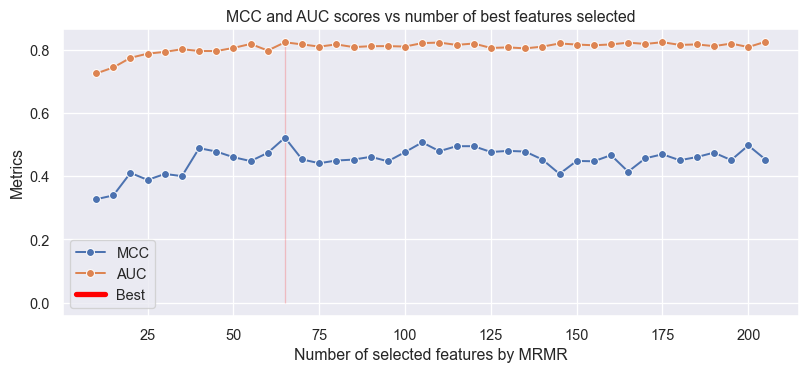

In [137]:
mcc_mrmr, auc_mrmr = plot_classification_metrics(results_mrmr, X_train)

In [175]:
# Added
# Take selected features by MRMR
selected_features_mr = features_mrmr[np.argmax(mcc_mrmr)]


In [ ]:
# Added
rnd_models_mr, metrics_rnd_mr = apply_randsearch(X_train[selected_features_mr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mr]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mr]
                                                        , X_val_norm[selected_features_mr])

### Applying Relief feature selection

In [148]:
# ADDED
# Applying Relief feature selection



In [149]:
# Added
n_neighbors = 100
models_rf, results_rf, num_sel_feat_rf, features_rf = fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True, n_neighbors)



=======================Selected features 10/207 =======================
MLPC | MCC: 0.474, AUC: 0.736, Accuracy: 0.703, Precision: 0.792, Recall: 0.735
SVC | MCC: 0.416, AUC: 0.706, Accuracy: 0.669, Precision: 0.780, Recall: 0.704
RFC | MCC: 0.585, AUC: 0.793, Accuracy: 0.776, Precision: 0.808, Recall: 0.792
DTC | MCC: 0.439, AUC: 0.719, Accuracy: 0.692, Precision: 0.761, Recall: 0.718
[00:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.579, AUC: 0.789, Accuracy: 0.760, Precision: 0.828, Recall: 0.788

=======================Selected features 15/207 =======================
MLPC | MCC: 0.487, AUC: 0.743, Accuracy: 0.721, Precision: 0.772, Recall: 0.743
SVC | MCC: 0.455, AUC: 0.726, Accuracy: 0.693, Precision: 0.783, Re

XGBC | MCC: 0.600, AUC: 0.800, Accuracy: 0.779, Precision: 0.823, Recall: 0.799

=======================Selected features 65/207 =======================
MLPC | MCC: 0.601, AUC: 0.801, Accuracy: 0.790, Precision: 0.806, Recall: 0.801
SVC | MCC: 0.570, AUC: 0.785, Accuracy: 0.759, Precision: 0.817, Recall: 0.784
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.795, Precision: 0.828, Recall: 0.812
DTC | MCC: 0.472, AUC: 0.736, Accuracy: 0.722, Precision: 0.746, Recall: 0.736
[01:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.591, AUC: 0.795, Accuracy: 0.777, Precision: 0.814, Recall: 0.795

=======================Selected features 70/207 =======================
MLPC | MCC: 0.543, AUC: 0.771, Accuracy: 0.745, Precision: 0.806, R

DTC | MCC: 0.518, AUC: 0.759, Accuracy: 0.732, Precision: 0.794, Recall: 0.758
[03:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.630, AUC: 0.815, Accuracy: 0.796, Precision: 0.834, Recall: 0.814

=======================Selected features 120/207 =======================
MLPC | MCC: 0.604, AUC: 0.801, Accuracy: 0.811, Precision: 0.775, Recall: 0.802
SVC | MCC: 0.566, AUC: 0.783, Accuracy: 0.764, Precision: 0.803, Recall: 0.783
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.790, Precision: 0.837, Recall: 0.812
DTC | MCC: 0.478, AUC: 0.738, Accuracy: 0.710, Precision: 0.780, Recall: 0.737
[03:29:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default

XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816

=======================Selected features 170/207 =======================
MLPC | MCC: 0.545, AUC: 0.772, Accuracy: 0.748, Precision: 0.803, Recall: 0.772
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.759, Precision: 0.808, Recall: 0.781
RFC | MCC: 0.645, AUC: 0.823, Accuracy: 0.809, Precision: 0.834, Recall: 0.823
DTC | MCC: 0.469, AUC: 0.734, Accuracy: 0.708, Precision: 0.772, Recall: 0.733
[05:05:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816

=======================Selected features 175/207 =======================
MLPC | MCC: 0.576, AUC: 0.788, Accuracy: 0.759, Precision: 0.825,

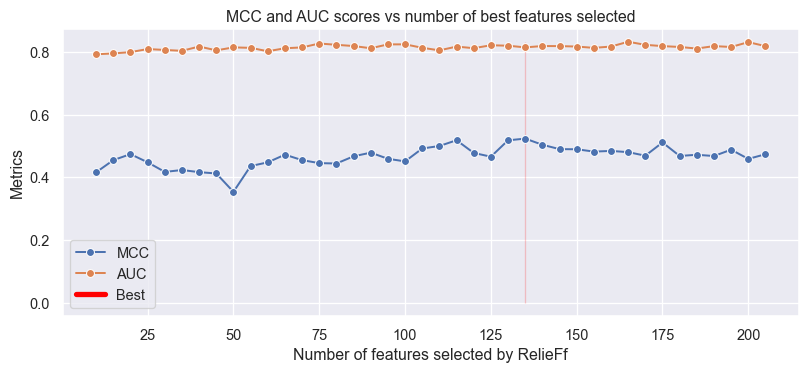

In [174]:
# Added
mcc_rf, auc_rf = plot_classification_metrics(results_rf, X_train, "RelieFf")

In [159]:
# ADDED
# Applying various feature selection algorithm supplied by the score_func


In [162]:
#Added
# Applying feature selection using scoring function as mutual_info_classification
models_mic, results_mic, num_sel_feat_mic, features_mic = fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True, mutual_info_classif)


=======================Selected features 10/207 =======================
MLPC | MCC: 0.532, AUC: 0.766, Accuracy: 0.738, Precision: 0.803, Recall: 0.765
SVC | MCC: 0.419, AUC: 0.709, Accuracy: 0.686, Precision: 0.744, Recall: 0.708
RFC | MCC: 0.566, AUC: 0.783, Accuracy: 0.768, Precision: 0.794, Recall: 0.783
DTC | MCC: 0.487, AUC: 0.743, Accuracy: 0.723, Precision: 0.766, Recall: 0.743
[14:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.771, Precision: 0.825, Recall: 0.795

=======================Selected features 15/207 =======================
MLPC | MCC: 0.489, AUC: 0.742, Accuracy: 0.700, Precision: 0.820, Recall: 0.740
SVC | MCC: 0.463, AUC: 0.730, Accuracy: 0.697, Precision: 0.789, Re

XGBC | MCC: 0.600, AUC: 0.800, Accuracy: 0.776, Precision: 0.828, Recall: 0.799

=======================Selected features 65/207 =======================
MLPC | MCC: 0.535, AUC: 0.768, Accuracy: 0.758, Precision: 0.769, Recall: 0.768
SVC | MCC: 0.538, AUC: 0.769, Accuracy: 0.738, Precision: 0.811, Recall: 0.768
RFC | MCC: 0.617, AUC: 0.808, Accuracy: 0.782, Precision: 0.839, Recall: 0.807
DTC | MCC: 0.481, AUC: 0.740, Accuracy: 0.724, Precision: 0.755, Recall: 0.740
[14:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.595, AUC: 0.797, Accuracy: 0.773, Precision: 0.825, Recall: 0.796

=======================Selected features 70/207 =======================
MLPC | MCC: 0.531, AUC: 0.763, Accuracy: 0.716, Precision: 0.845, R

DTC | MCC: 0.473, AUC: 0.736, Accuracy: 0.718, Precision: 0.755, Recall: 0.736
[14:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.607, AUC: 0.803, Accuracy: 0.791, Precision: 0.811, Recall: 0.803

=======================Selected features 120/207 =======================
MLPC | MCC: 0.538, AUC: 0.769, Accuracy: 0.758, Precision: 0.775, Recall: 0.769
SVC | MCC: 0.546, AUC: 0.772, Accuracy: 0.747, Precision: 0.806, Recall: 0.772
RFC | MCC: 0.656, AUC: 0.828, Accuracy: 0.818, Precision: 0.834, Recall: 0.828
DTC | MCC: 0.483, AUC: 0.741, Accuracy: 0.715, Precision: 0.777, Recall: 0.740
[14:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default

XGBC | MCC: 0.604, AUC: 0.802, Accuracy: 0.789, Precision: 0.811, Recall: 0.802

=======================Selected features 170/207 =======================
MLPC | MCC: 0.565, AUC: 0.783, Accuracy: 0.771, Precision: 0.789, Recall: 0.783
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.767, Precision: 0.808, Recall: 0.787
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.799, Precision: 0.842, Recall: 0.820
DTC | MCC: 0.473, AUC: 0.736, Accuracy: 0.716, Precision: 0.761, Recall: 0.736
[14:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.622, AUC: 0.811, Accuracy: 0.788, Precision: 0.837, Recall: 0.810

=======================Selected features 175/207 =======================
MLPC | MCC: 0.591, AUC: 0.795, Accuracy: 0.780, Precision: 0.808,

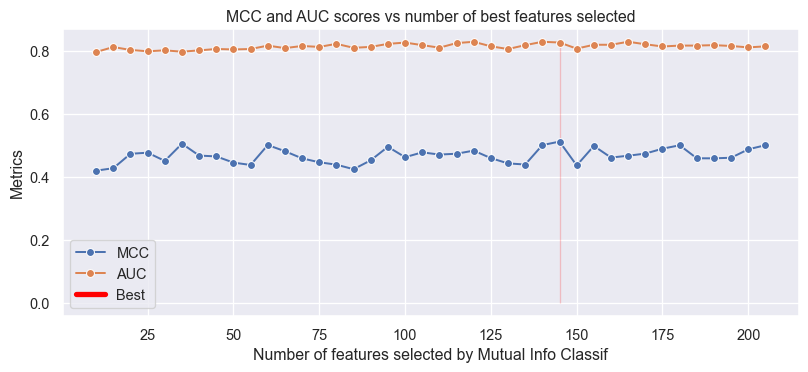

In [173]:
# Added
mcc_mic, auc_mic = plot_classification_metrics(results_mic, X_train, "Mutual Info Classif")